#### read data

In [1]:
import pandas as pd
import os

def get_data():
    base_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\train_df.pkl\train_df.pkl"
    embedding_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\train_df.pkl\train_node2vec_embeddings.pkl"
    more_id_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\train_df.pkl\more_train_id_features.pkl"
    output = pd.read_pickle(base_path)
    # embedding features e.g embedding_merchant_id_1
    temp = pd.read_pickle(embedding_path)
    output = output.merge(temp, how = "left", on = "card_id")
    # id_features e.g nunique_merchant_id
    temp = pd.read_pickle(more_id_path)
    output = output.merge(temp, how = "left", on = "card_id")
    # similarity_features e.g marchant_id_similarity_min
    node_similarity_feature_dir = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\node2vec similarities"
    os.chdir(node_similarity_feature_dir)
    for filename in os.listdir(node_similarity_feature_dir):
        temp = pd.read_pickle(filename)
        output = output.merge(temp, how = "left", on = "card_id")
    return output

In [2]:
data = get_data()

In [5]:
list(data.columns)

['card_id',
 'old_hist_count',
 'old_authorized_flag__0_count',
 'old_authorized_flag__1_count',
 'old_authorized_flag__0_fraction',
 'old_authorized_flag__1_fraction',
 'old_category_1__0_count',
 'old_category_1__1_count',
 'old_category_1__0_fraction',
 'old_category_1__1_fraction',
 'old_category_2__1.0_count',
 'old_category_2__2.0_count',
 'old_category_2__3.0_count',
 'old_category_2__4.0_count',
 'old_category_2__5.0_count',
 'old_category_2__1.0_fraction',
 'old_category_2__2.0_fraction',
 'old_category_2__3.0_fraction',
 'old_category_2__4.0_fraction',
 'old_category_2__5.0_fraction',
 'old_category_3__A_count',
 'old_category_3__B_count',
 'old_category_3__C_count',
 'old_category_3__A_fraction',
 'old_category_3__B_fraction',
 'old_category_3__C_fraction',
 'old_city_id_bins__(3.806, 9.441]_count',
 'old_city_id_bins__(9.441, 9.928]_count',
 'old_city_id_bins__(9.928, 10.474]_count',
 'old_city_id_bins__(10.474, 11.183]_count',
 'old_city_id_bins__(11.183, 15.391]_count',
 

#### additional features: month and year

In [3]:
datetime_features = ["old_purchase_date_max", "old_purchase_date_min", "new_purchase_date_max", "new_purchase_date_min", "first_active_month"]
def add_year_month_features(data, features):
    for feature in features:
        data[f"{feature}_month"] = data[feature].apply(lambda date: date.month)
        data[f"{feature}_year"] = data[feature].apply(lambda date: date.year)
    return data
data = add_year_month_features(data,datetime_features)

#### find columns with too many NAs

In [6]:
too_many_na_features = []
threshold = 0.4

na = data.isna().sum()/len(data)
for feature, num_na in na.items():
    if num_na>threshold:
        too_many_na_features.append(feature)

In [7]:
len(too_many_na_features)

96

#### columns eliminated by backward selection

In [6]:
eliminated_features = [
    'feature1_5','new_merchant_category_id_bins_5_822_7_156_count','new_city_id_bins_6_778_7_249_count',
    'count_state_id','new_city_id_bins_1_608_6_778_count','feature3_0',
    'new_state_id_bins_5_877_9_474_count','new_merchant_category_id_bins_3_434_5_822_count','count_city_id',
    'new_merchant_category_id_bins_0_001_3_434_count','new_merchant_category_id_bins_0_001_3_434_fraction','old_purchase_date_min_year',
    'new_purchase_date_max_year','new_subsector_id_bins_2_0780000000000003_7_706_count','new_purchase_date_min_year',
    'new_subsector_id_bins_2_0780000000000003_7_706_fraction','feature3_1'
]

#### define training columns

In [7]:
import re
def clean_colname(colname):
    return re.sub('[^A-Za-z0-9]+', '_', colname)
data.columns = [clean_colname(col) for col in data.columns]

In [8]:
#define columns
X_cols = [col for col in data.columns if col not in ["target","card_id",*too_many_na_features, *datetime_features, *eliminated_features]]
y_col = "target"
categorical_feature = [
    'feature1_1', 'feature1_2', 'feature1_3', 'feature1_4', 'feature1_5', 'feature2_1', 'feature2_2', 'feature2_3', 'feature3_0', 'feature3_1',
    "feature_sum","feature_max","feature_min", "quarter","feature_1","feature_2","feature_3",'first_active_month_month',
    'first_active_month_year', 'old_purchase_date_max_month',
    'old_purchase_date_max_year', 'old_purchase_date_min_month',
    'old_purchase_date_min_year','new_purchase_date_max_month', 'new_purchase_date_max_year',
    'new_purchase_date_min_month', 'new_purchase_date_min_year'
]

#### label encoding

In [12]:
def first_active_month_year_encoder(value):
    mappings={
        2017:0,
        2016:1,
        2015:2,
        2014:3,
        2013:4 , 
        2012:4,   
        2018:4,    
        2011:4    
    }
    return mappings.get(value, 0)
def old_purchase_date_max_year_encoder(value):
    mappings={
        2018:0,
        2017:1 
    }
    return mappings.get(value, 0)
data['first_active_month_year'] = data['first_active_month_year'].map(first_active_month_year_encoder)
data['old_purchase_date_max_year'] = data['old_purchase_date_max_year'].map(old_purchase_date_max_year_encoder)

In [51]:
# from sklearn.preprocessing import LabelEncoder
# cols_to_encode = ["first_active_month_year", "old_purchase_date_max_year"]
# first_active_month_year_encoder = LabelEncoder()
# first_active_month_year_encoder.fit(X["first_active_month_year"])
# old_purchase_date_max_year_encoder = LabelEncoder()
# old_purchase_date_max_year_encoder.fit(X["old_purchase_date_max_year"])
# X["first_active_month_year"] = first_active_month_year_encoder.transform(X["first_active_month_year"])
# X["old_purchase_date_max_year"] = old_purchase_date_max_year_encoder.transform(X["old_purchase_date_max_year"])

In [ ]:
# X, y = data[X_cols], data[y_col]

### save lgb dataset

In [21]:
# import lightgbm as lgb
# lgb_data = lgb.Dataset(X, label = y, categorical_feature = categorical_feature, feature_name = list(X.columns), weight = None)

In [22]:
# path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\train.bin"
# lgb_data.save_binary(path)

### save pickle

In [13]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\full_train2.pkl"
data[["card_id",y_col]+X_cols].to_pickle(path)

## Repeat for test set

In [17]:
import pandas as pd

def get_data():
    base_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\train_df.pkl\test_df.pkl"
    embedding_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\train_df.pkl\test_node2vec_embeddings.pkl"
    more_id_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\train_df.pkl\more_test_id_features.pkl"
    output = pd.read_pickle(base_path)
    # embedding features e.g embedding_merchant_id_1
    temp = pd.read_pickle(embedding_path)
    output = output.merge(temp, how = "left", on = "card_id")
    # id_features e.g nunique_merchant_id
    temp = pd.read_pickle(more_id_path)
    output = output.merge(temp, how = "left", on = "card_id")
    # similarity_features e.g marchant_id_similarity_min
    node_similarity_feature_dir = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\node2vec similarities"
    os.chdir(node_similarity_feature_dir)
    for filename in os.listdir(node_similarity_feature_dir):
        temp = pd.read_pickle(filename)
        output = output.merge(temp, how = "left", on = "card_id")
    return output
data = get_data()
datetime_features = ["old_purchase_date_max", "old_purchase_date_min", "new_purchase_date_max", "new_purchase_date_min", "first_active_month"]
data = add_year_month_features(data,datetime_features)
data.columns = [clean_colname(col) for col in data.columns]
data['first_active_month_year'] = data['first_active_month_year'].map(first_active_month_year_encoder)
data['old_purchase_date_max_year'] = data['old_purchase_date_max_year'].map(old_purchase_date_max_year_encoder)

In [18]:
X = data[["card_id"] + X_cols]

### save pickle

In [19]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4041 - Machine Learning\Team Project\data\full_test2.pkl"
X.to_pickle(path)

<AxesSubplot:>

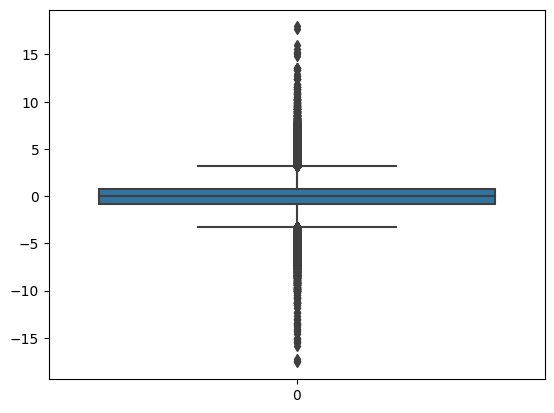

In [49]:
from seaborn import boxplot
boxplot(data = data.target[data.target>min(data.target)])